In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [6]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download=True,
    transform=ToTensor()
)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

N_train, D1, D2 = train_data.data.shape
Nc = 10

In [8]:
class Model(nn.Module):
    def __init__(self, D1, D2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 5, (2,2)),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(5*D1*D2, 10)
        )
    def forward(self, x):
        return self.cnn(x)

In [45]:
class Model(nn.Module):
    def __init__(self, D1, D2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * (D1 // 2) * (D2 // 2), 128),  # 입력 크기 수정
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.cnn(x)

In [63]:
prt = lambda s, loss, acc: print(f"{s}: loss={loss:>.2e}, accuracy={acc:>.2f}")  
perf = {"Train": {"loss": [], "accuracy": []},
        "Test": {"loss": [], "accuracy": []}}
def save_results(dct, loss, acc):
    dct["loss"].append(loss)
    dct["accuracy"].append(acc)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = Model(D1, D2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_f = torch.nn.CrossEntropyLoss()
n_epoch = 10

for epoch in range(n_epoch):
    print(f"Epoch: {epoch}")
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_f(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_acc = (pred.argmax(dim=1) == y).type(torch.float).sum().item() / len(y)
    train_loss = loss.item()
    prt("Train", train_loss, train_acc) 
    save_results(perf["Train"], train_loss, train_acc)

    with torch.no_grad():
        sz = len(test_loader.dataset)
        n_batch = len(test_loader)
        test_acc = 0
        test_loss = 0
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_acc += (pred.argmax(dim=1)==y).type(torch.float).sum().item()
            loss = loss_f(pred, y)
            test_loss += loss.item()
        test_acc /= sz
        test_loss /= n_batch
        prt("Test", test_loss, test_acc) 
        save_results(perf["Test"], test_loss, test_acc)

cuda
Epoch: 0
Train: loss=1.52e+00, accuracy=0.69
Test: loss=1.48e+00, accuracy=0.66
Epoch: 1
Train: loss=1.00e+00, accuracy=0.72
Test: loss=9.65e-01, accuracy=0.71
Epoch: 2
Train: loss=8.37e-01, accuracy=0.72
Test: loss=7.97e-01, accuracy=0.74
Epoch: 3
Train: loss=7.61e-01, accuracy=0.72
Test: loss=7.19e-01, accuracy=0.75
Epoch: 4
Train: loss=7.19e-01, accuracy=0.72
Test: loss=6.71e-01, accuracy=0.76
Epoch: 5
Train: loss=6.89e-01, accuracy=0.72
Test: loss=6.38e-01, accuracy=0.77
Epoch: 6
Train: loss=6.67e-01, accuracy=0.75
Test: loss=6.12e-01, accuracy=0.78
Epoch: 7
Train: loss=6.49e-01, accuracy=0.75
Test: loss=5.91e-01, accuracy=0.79
Epoch: 8
Train: loss=6.32e-01, accuracy=0.75
Test: loss=5.74e-01, accuracy=0.79
Epoch: 9
Train: loss=6.17e-01, accuracy=0.75
Test: loss=5.59e-01, accuracy=0.80


Text(0.5, 1.0, 'Loss')

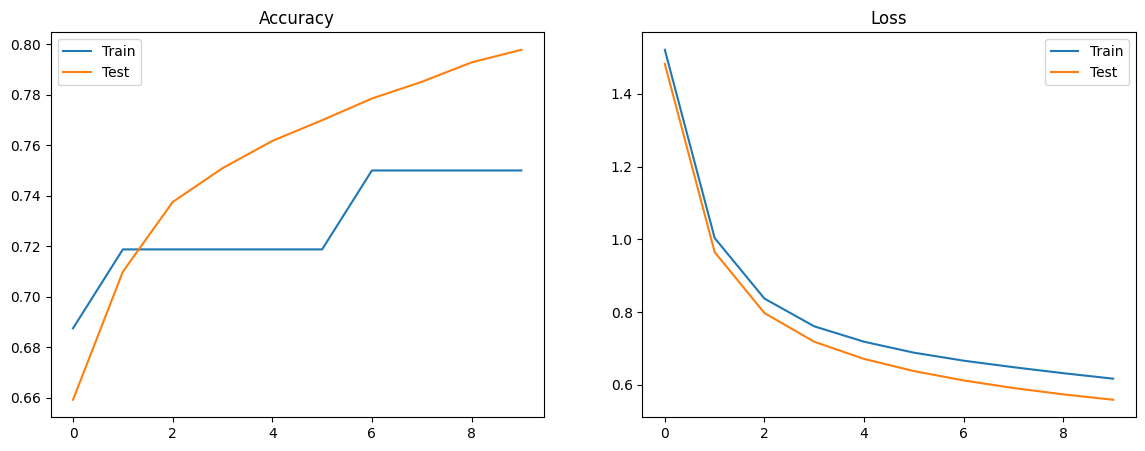

In [64]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(perf["Train"]["accuracy"], label='Train')
plt.plot(perf["Test"]["accuracy"], label='Test')
plt.legend()
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(perf["Train"]["loss"], label="Train")
plt.plot(perf["Test"]["loss"], label="Test")
plt.legend()
plt.title("Loss")